# Analysis of one simulation (Izhikevich model)

In this notebook you will see the code that simulates the evolution of a system that follows the Izhikevich model. This system is made with four networks of 7 neurons fully connected. The different networks are connected between them by 4 different connections neuron to neuron. 

In [10]:
import numpy as np
import matplotlib.pyplot as plt

The first step is to define the weight matrix W. It indicates the probablity that the neuron $i$ (rows) is connected with the neuron $j$ (columns), so it takes for every position a value $W_{ij} \in [0,1],\ \forall i,j$. In this model I studied it takes only 0 (if they are not connected) or 1 (if they are connected). 

The dimension of this matrix is $28\times 28$. The values for the connections between neurons of the same lattice take 1 and the rest is determined by the system.

In this case I defined the systems in which the connections are $1 \to 2 \to 4$ and $1 \to 3 \to 4$, but 2 and 3 are not connected to 1 and the same occurs with 4 with 2 and 3. This system is called "directional system" as it has a clear direction in the connections made. (The system scheme can be seen in the "memory")

There is another wight matrix defined for a system in which the connections are $1 \to 2 \to 4\to 3 \to 1$, but is not used in the code. This is the "non-directional system" as the connections are not pointing to the same direction.

In [11]:
def directional_matrix(Nn):

    Wij = np.zeros((Nn,Nn, 4)) # Above diagonal, W12, W13, W24, W34
    Wji = np.zeros((Nn,Nn, 4)) # Below diagonal, W21, W31, W42, W43

    
    Wd = np.ones((Nn,Nn))
    np.fill_diagonal(Wd,0)
    
    W14 = np.zeros((Nn,Nn))
    W23 = np.zeros((Nn,Nn)) 
    
    
    for k in range(4):
        indices = np.random.choice(49, 4, replace=False)
        for i in range(4):
            fila, columna = divmod(indices[i], 7)
            Wij[fila, columna,k] = 1
    
    W1 = np.hstack((        Wd, Wij[:,:,0], Wij[:,:,1] ,    W14         ))
    W2 = np.hstack(( Wji[:,:,0], Wd       , W23        ,    Wij[:,:,2]  ))
    W3 = np.hstack(( Wji[:,:,1], W23       , Wd        ,    Wij[:,:,3]  ))
    W4 = np.hstack((        W14, Wji[:,:,2], Wji[:,:,3] ,    Wd         ))
    
    return np.vstack((W1,
                      W2,
                      W3,
                      W4))


def nondirectional_matrix(Nn):

    Wij = np.zeros((Nn,Nn, 4)) # Above the diagonal, W12, W13, W24, W34
    Wji = np.zeros((Nn,Nn, 4)) # Below the diagonal, W21, W31, W42, W43

    Wd = np.ones((Nn,Nn))
    np.fill_diagonal(Wd,0)
    
    W14 = np.zeros((Nn,Nn))
    W23 = np.zeros((Nn,Nn)) 
    
    
    for k in range(4):
        indices = np.random.choice(49, 4, replace=False)
        for i in range(2):
            fila, columna = divmod(indices[i], 7)
            fila2, columna2 = divmod(indices[i+2], 7)
            Wij[fila, columna,k] = 1
            Wji[fila2, columna2,k] = 1
    
    W1 = np.hstack((        Wd, Wij[:,:,0], Wij[:,:,1] ,    W14         ))
    W2 = np.hstack(( Wji[:,:,0], Wd       , W23        ,    Wij[:,:,2]  ))
    W3 = np.hstack(( Wji[:,:,1], W23       , Wd        ,    Wij[:,:,3]  ))
    W4 = np.hstack((        W14, Wji[:,:,2], Wji[:,:,3] ,    Wd         ))
    
    return np.vstack((W1,
                      W2,
                      W3,
                      W4))

In this cell is where the simulation takes place. To begin is needed to define the parameters $a$, $b$, $c$ and $d$, the matrix $W$ and the initial conditions of $v_i$ and $u_i$ for each neuron (in this case $v_i$ takes a random value between -65 and 0 and ). It is also needed to define the delay matrix, to know the delay between the neurons $i$ and $j$ and, obviously, the total of time the system will be evolving. When this ends, it returns the value of $v_i$, $u_i$ and the firings there have been at every step.

This code is a particular case where the SD is 1.78 (the one where $\phi_{FC}$ is maximum) and the total of time is 100000 ms with a time-step of 1 ms. It can take 20-30 min to finish.

In [ ]:
N = 7 # Neurones per reticle
Nt = N * 4 # Total number of neurons

W = directional_matrix(N)
# W = nondirectional_matrix(N)

t_total = 100000 #ms, total time of simulation. It increases parabolically the time of simulation but an approximation has been made to make it linear in the number of iterations.

# Parameters for regular spiking neurons
a = .02
b = .2
c = -65 # mV
d = 8

# Matrices to store the membrane potential and the recovery variable
v = np.zeros((Nt, t_total))
u = np.zeros((Nt, t_total))

# Initial conditions
v[:,0] = c*np.random.rand(Nt)
u[:,0] = b*v[:,0]

# Delay matrix, gaussian with mean 0.6 and standard deviation 0.1
delay = .1*np.random.randn(Nt,Nt) + .6

firings_2 = []
firings = [[] for k in range(Nt)]

for t in range(1,t_total):
    
    I_ij = np.zeros((Nt,Nt))
    
    f = np.where( v[:,t-1] >= 30 )[0] # Neurons that have fired at the previous time step
    
    # As there is a certain delay in the synaptic current that goes from one neuron to another,
    # I don't consider the firings that occur at the same time. All neurons that fire at the same time
    # will be reset at the same time, and the next iteration will receive the impulse of those that have fired.
    
    # The neurons that have fired are reset and it is specified that they have fired when the voltage reaches 30 mV.
    v[f,t-1] = c
    v[f,t-2] = 30
    u[f,t-1] = u[f,t-1] + d
    
    # The firings are stored in a list, firings_2, which contains tuples of the time and neuron index. It is used to plot them.
    firings_2.extend([(t, j) for j in f])
    
    # The firings are stored in a list of lists, firings, where each index corresponds to a neuron and contains the times at which it has fired.
    # This is used to calculate the synaptic current that each neuron receives from the others.
    for k in f:
        firings[k].append(t)
    
    # The synaptic current is calculated for each neuron, taking into account the delay and the firings of the other neurons.
    for i in range(Nt):
        tl = np.array(firings[i])# Neurons that have fired before the current time
        # If the number of firings is greater than 80, only the last 80 firings are considered to avoid overflow.
        if np.size(tl) > 80:
            tl = tl[-80:]

        if np.size(tl) == 0:
            pass
        else:
            for j in range(Nt):
                I_ij[i,j] =  4*W[i,j]*np.sum(np.exp(-((t-delay[i,j])*np.ones(np.size(tl))-tl)/10)*np.heaviside((t-delay[i,j])*np.ones(np.size(tl))-tl, 1)) 
    I = np.sum(I_ij, axis = 0)
    
    # The noise is added to v, which is the membrane potential of the neurons and is a Gaussian noise with a standard deviation of 4 and mean 3.
    noise = 1.7807663910213452 * np.random.randn(Nt) +3 
    
    # The membrane potential and the recovery variable are updated using the Izhikevich model equations with the Euler method.
    v[:,t] = v[:,t-1] + 1*(.04 * v[:,t-1]**2 + 5.* v[:,t-1] + 140 - u[:,t-1]+ noise + I)
    u[:,t] = u[:,t-1] + (a * (b * v[:,t-1] - u[:,t-1]))


From here on it will take place the analysis section. Firstly is needed to calculate the correlation matrix $r_{ij}$ to quantify the correlations between all the neurons. To do this it has been used a method very similar to the "binary windowing" or "binning". The firing evolution of a neuron can be represented by a binary array (1 if the neuron fired, 0 if not). As there is certain delay and neurons connected will receive the synaptic impulse at a different step of time, to analyze properly the dynamics it is needed to reduce the array on windows with a similar size as the average time between firings. The position of a certain window will take 1 if the neuron fired on that gap of time and 0 if not. Finally the calculus of the correlation matrix will be done with the reduced array. 

The prints of below correspond to the average of time (or iterations) between 2 consecutevely firings and the other the window size selected.

In [13]:
fir_rate = np.empty(Nt)
r = np.zeros((Nt,Nt))
desv = np.zeros(Nt)
mitj = np.zeros(Nt)
fires = (v == 30).astype(int)
fires = fires[:,200:]

# The number of firings per neuron is calculated, and the average firing rate is calculated.
# The average firing rate is the number of firings divided by the total time in seconds.
# If there are no firings, the average firing rate is set to 0.
# The first 200 ms are discarded to avoid the transient state of the system.
for i in range(Nt):
    fir = np.where(fires[i,:] == 1)[0]
    if np.size(fir) == 0:
        mitj[i] = 0
    else:
        itera_per_fi = (t_total-200)/len(fir)
        mitj[i] = itera_per_fi
        

# The average firing rate is calculated as the mean of the firing rates of all neurons.
# If there are no firings or just one neuron fires, the average firing rate is set to 0.
w = np.where(mitj != 0)[0]

if np.size(w) >= 2:
    mitja = np.mean(mitj[w])
    sep = max(1,mitja//3*2) #ms
else:
    mitja = 0
    sep = 1

print(mitja, sep)


n_arr = np.round((t_total-200)/sep)

while (np.size(fires,1))%(n_arr) != 0:
    fires = fires[:,1:]

fires_scaled = np.zeros((0,Nt))

sub_arrays = np.split(fires[:], n_arr, axis=1)

for i in range(len(sub_arrays)):
    fires_scaled = np.vstack((fires_scaled, np.any(sub_arrays[i], axis=1)))

fires_scaled = fires_scaled.astype(int).T

for i in range(Nt):
    fir_rate[i] = 1/1000*np.size(np.where(fires_scaled[i] == 1))
    desv[i] = np.sqrt(np.sum((fires_scaled[i,:]-fir_rate[i])**2))

# If the standard deviation is 0, the correlation is set to 0 to avoid division by zero.
for i in range(Nt):
    if desv[i] == 0:
        r[i,:] = 0
    else:
        for j in range(Nt):
            if desv[j] == 0:
                r[i,j] = 0
            else:
                r[i,j] = np.sum(( fires_scaled[i,:] - fir_rate[i] ) * ( fires_scaled[j,:] - fir_rate[j] ))/(desv[i] * desv[j])




158.47048058250274 104.0


In this cell there is a heat map of the matrix correlation and is compared to the weight matrix. The correlations of neurons of the same network is nearly 1 as they are all connected and the correlation of a neuron with itself is exactly 1. The print that is above the plot is the number of the smallest value of the correlations matrix. 

0.130343869270546


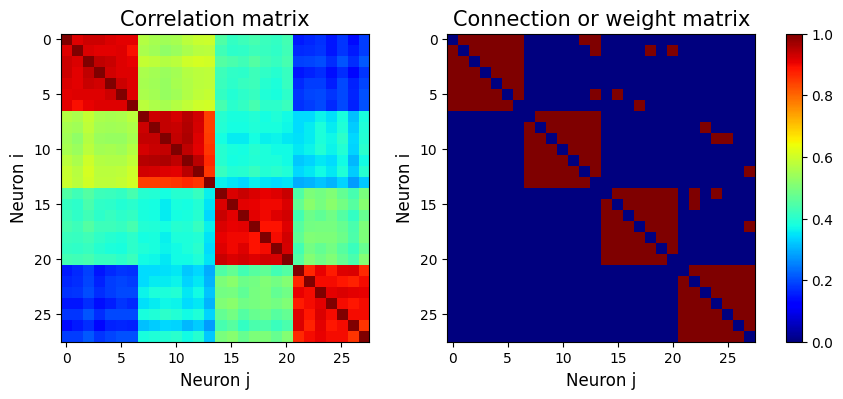

In [14]:
fig, ax = plt.subplots(1,2,figsize = (10,4))
ax[0].set_title('Correlation matrix', fontsize = 15)
ax[0].set_xlabel('Neuron j', fontsize = 12)
ax[0].set_ylabel('Neuron i', fontsize = 12)
cax = ax[0].imshow(r, cmap='jet', interpolation='nearest', vmin = 0, vmax = 1)
ax[1].set_title('Connection or weight matrix', fontsize = 15)
ax[1].set_xlabel('Neuron j', fontsize = 12)
ax[1].set_ylabel('Neuron i', fontsize = 12)
cax = ax[1].imshow(W, cmap='jet', interpolation='nearest', vmin = 0, vmax = 1)
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
print(np.min(r))
plt.show()

The calculus of the functional complexity is given by a histogram. The number of boxes is 20 and the values of $r_{ij}$ that correspond to neurons of the same lattice are discarded as they are always near to 1 and the interest is to see the correlation of different networks.

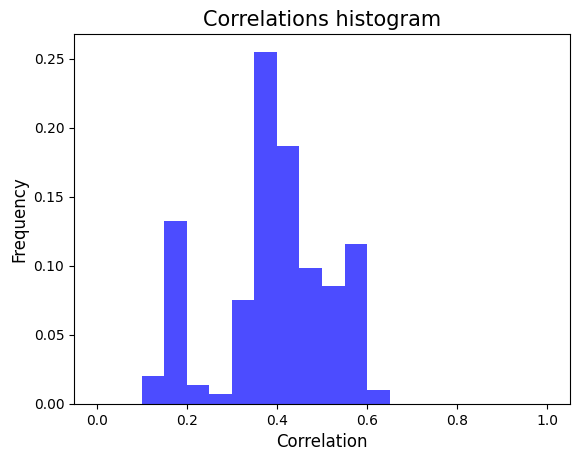

Functional complexity: 0.3694951664876477


In [15]:
B = 20

hg, _ = np.histogram(r, bins = B, range = (-0.0001,1.0001)) # It is necessary to add a small value to the range to avoid empty bins at the edges.
hg1,boxsize = np.histogram(r[:7, :7], bins=B, range=(-0.0001, 1.0001))
hg2,_ = np.histogram(r[7:14, 7:14], bins=B, range=(-0.0001, 1.0001))
hg3,_ = np.histogram(r[14:21, 14:21], bins=B, range=(-0.0001, 1.0001))
hg4,_ = np.histogram(r[21:28, 21:28], bins=B, range=(-0.0001, 1.0001))

hg = hg - hg1 -hg2 - hg3 - hg4 

bin_edges = np.array([(1/(2*B) + 1/B*i) for i in range(B)])

# Normalize the histogram
hg = hg/(28*21)
hg = np.maximum(hg, 0)

plt.bar(bin_edges, hg, width = 1/B, color = 'b', alpha = 0.7)
plt.xlabel('Correlation', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Correlations histogram', fontsize = 15)
plt.show()

func_complexity = 1- B/(2*(B-1))*np.sum(np.abs(hg-1/B))
# If the histogram is empty, the complexity is set to 0 to avoid negative small values due to computational errors.
func_complexity = np.maximum(func_complexity, 0)
print(f'Functional complexity: {func_complexity}')


What can be seen from here on is some graphics that show the behaviour of the membrane potential $v$, the recovery variable $u$ and the ensemble of firings of all neurons in a reduced time window. It can be seen some patterns of collective bursting as the is a period of firing of all neurons at the same time and then stop all of them at the same moment.

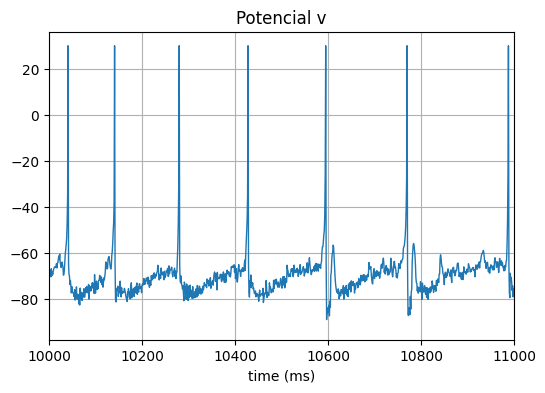

In [16]:
p = 7

plt.figure(figsize=(6, 4))

plt.title('Potencial v') # Membrane potential of neuron 7
plt.plot(np.linspace(0,t_total,t_total, endpoint = True),v[p,:], lw = 1)
plt.xlabel('time (ms)') # time
plt.xlim(10000, 11000)
plt.grid()
plt.savefig('v_potencial.pdf', bbox_inches='tight')

plt.show()

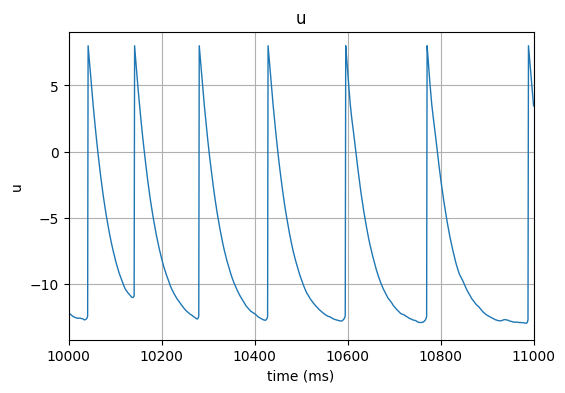

In [17]:
plt.figure(figsize=(6, 4))
plt.title('u') # Recovery variable of neuron 7
plt.plot(np.linspace(0,t_total,t_total, endpoint = True),u[p,:], lw = 1)
plt.xlim(10000, 11000)
plt.ylabel('u')
plt.xlabel('time (ms)') # time
plt.grid()
plt.savefig('u_recovery.pdf', bbox_inches='tight')
plt.show()

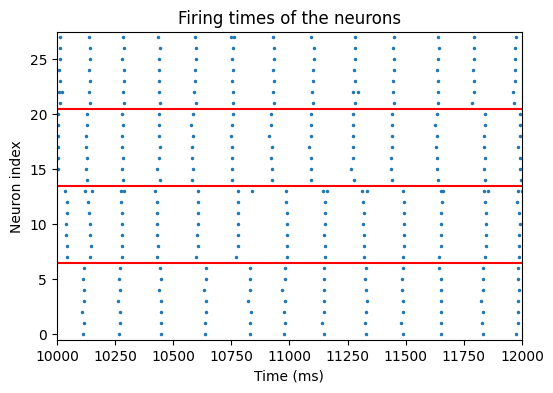

In [18]:
firings_2 = np.array(firings_2)

plt.figure(figsize=(6, 4))
plt.plot(firings_2[:,0], firings_2[:,1], 'o', markersize = 1.5)
plt.axhline((6.5) , color = 'r')
plt.axhline((13.5), color = 'r')
plt.axhline((20.5), color = 'r')
plt.ylim(-0.5, 27.5)
plt.xlim(10000, 12000)
plt.title('Firing times of the neurons')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')

plt.savefig('firing_times.pdf', bbox_inches='tight')
plt.show()